# Assessment

### Install API packages

In [38]:
%pip install sodapy

Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sodapy import Socrata
import seaborn as sns
import warnings
import geopandas as gpd
from shapely.geometry import Point
warnings.filterwarnings('ignore')

### Set up APIs

In [ ]:
URL_INSPECTIONS = 'https://data.lacity.org/resource/9w5z-rg2h.json'


client = Socrata("data.lacity.org", None)


### Source data from remote

In [41]:
raw_data = client.get("9w5z-rg2h")
raw_data_df = pd.DataFrame.from_records(raw_data)

### Exploratory data analysis

In [42]:
raw_data_df.head()

,address,permit,permit_status,inspection_date,inspection,inspection_result,lat_lon,:@computed_region_qz3q_ghft,:@computed_region_kqwf_mjcx,:@computed_region_k96s_3jcv,:@computed_region_tatf_ua23,:@computed_region_ur2y_g4cx,:@computed_region_2dna_qi2s
0,10000 W SANTA MONICA BLVD,14044 10000 02293,Issued,2016-07-20T00:00:00.000,Rough-Ventilation,Partial Approval,"{'latitude': '34.06364', 'longitude': '-118.41...",24032,6,870,739,9,75
1,1000 S SANTA FE AVE,15016 10000 18196,Permit Finaled,2016-07-22T00:00:00.000,Smoke Detectors,Insp Cancelled,"{'latitude': '34.03143', 'longitude': '-118.22...",23082,9,533,1287,NaN,76
2,3680 N BUENA PARK DR,15014 10000 04931,Issued,2016-07-18T00:00:00.000,Insulation,Approved,"{'latitude': '34.13745', 'longitude': '-118.38...",8492,5,351,1353,NaN,84
3,1001 N LINDENWOOD LANE,16042 90000 14712,Permit Finaled,2016-07-20T00:00:00.000,Final,Permit Finaled,"{'latitude': '34.07732', 'longitude': '-118.48...",23680,10,830,780,NaN,NaN
4,2836 S ANCHOR AVE,15016 20001 17211,CofO Issued,2016-07-18T00:00:00.000,Inspection,Permit Finaled,"{'latitude': '34.03878', 'longitude': '-118.39...",24029,6,872,1100,9,95


#### Drop unused columns

In [43]:
columns_to_keep = [
    'address',
    'permit',
    'permit_status',
    'inspection_date',
    'inspection',
    'inspection_result',
    'lat_lon'
]

In [44]:
trimmed_df = raw_data_df[columns_to_keep].copy()

In [45]:
trimmed_df.head()

,address,permit,permit_status,inspection_date,inspection,inspection_result,lat_lon
0,10000 W SANTA MONICA BLVD,14044 10000 02293,Issued,2016-07-20T00:00:00.000,Rough-Ventilation,Partial Approval,"{'latitude': '34.06364', 'longitude': '-118.41..."
1,1000 S SANTA FE AVE,15016 10000 18196,Permit Finaled,2016-07-22T00:00:00.000,Smoke Detectors,Insp Cancelled,"{'latitude': '34.03143', 'longitude': '-118.22..."
2,3680 N BUENA PARK DR,15014 10000 04931,Issued,2016-07-18T00:00:00.000,Insulation,Approved,"{'latitude': '34.13745', 'longitude': '-118.38..."
3,1001 N LINDENWOOD LANE,16042 90000 14712,Permit Finaled,2016-07-20T00:00:00.000,Final,Permit Finaled,"{'latitude': '34.07732', 'longitude': '-118.48..."
4,2836 S ANCHOR AVE,15016 20001 17211,CofO Issued,2016-07-18T00:00:00.000,Inspection,Permit Finaled,"{'latitude': '34.03878', 'longitude': '-118.39..."


#### Missing values

In [46]:
trimmed_df.isnull().sum()

address              0
permit               0
permit_status        0
inspection_date      0
inspection           0
inspection_result    0
lat_lon              0
dtype: int64

#### Basic summary

In [47]:
trimmed_df.shape

(1000, 7)

In [48]:
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   address            1000 non-null   object
 1   permit             1000 non-null   object
 2   permit_status      1000 non-null   object
 3   inspection_date    1000 non-null   object
 4   inspection         1000 non-null   object
 5   inspection_result  1000 non-null   object
 6   lat_lon            1000 non-null   object
dtypes: object(7)
memory usage: 54.8+ KB


### 

#### Convert data type

In [49]:
trimmed_df['inspection_date'] = pd.to_datetime(trimmed_df['inspection_date'])

## Question 1

Table: Top 10 Most Common Inspection Types
                  Inspection Type  Count  Percentage
0                           Final    241        24.1
1                           Rough    103        10.3
2                      Inspection     55         5.5
3                 Smoke Detectors     31         3.1
4         Footing/Foundation/Slab     28         2.8
5     SGSOV-Seismic Gas S/O Valve     24         2.4
6                 Drywall Nailing     23         2.3
7                  PLUMBING-Rough     22         2.2
8           Service/Power Release     22         2.2
9  Excavation/Setback/Form/Re-Bar     21         2.1


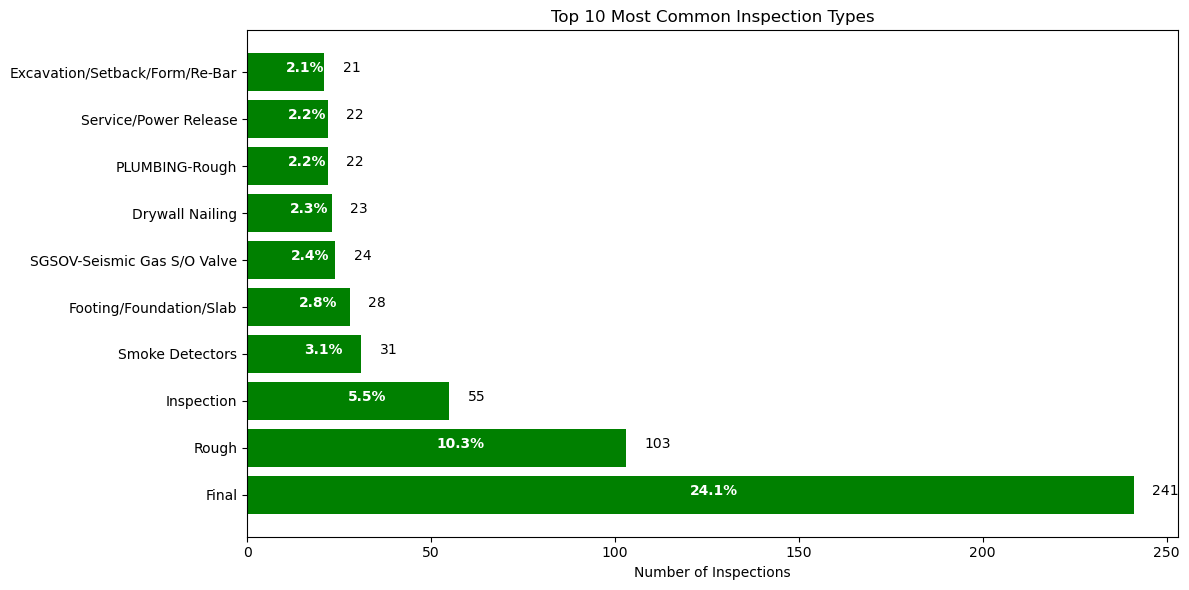

In [50]:
# Count inspection types
counts = trimmed_df['inspection'].value_counts().reset_index()
counts.columns = ['Inspection Type', 'Count']

# Add percentages
counts['Percentage'] = (counts['Count'] / counts['Count'].sum() * 100).round(1)

# Get top 10
top10 = counts.head(10)

# Print table
print("Table: Top 10 Most Common Inspection Types")
print(top10)

# Make bar chart
plt.figure(figsize=(12, 6))
plt.barh(top10['Inspection Type'], top10['Count'], color='green')

# Add labels
for i, count in enumerate(top10['Count']):
    plt.text(count + 5, i, str(count))
    plt.text(count/2, i, f"{top10['Percentage'][i]}%", color='white', fontweight='bold')

plt.title('Top 10 Most Common Inspection Types')
plt.xlabel('Number of Inspections')
plt.tight_layout()

plt.show()

#### Pattern Analysis:


Most common inspection: 'Final' (24.1%). Top 3 types make up 39.900000000000006%.


This result suggests that LA focuses mainly on Final, Rough, and other safety elements.

## Question 2

Table: Inspections by Region
      Region  Count  Percentage
0  Southeast    315        31.5
1  Northwest    315        31.5
2  Southwest    185        18.5
3  Northeast    185        18.5
Region with most inspections: Southeast
Region with fewest inspections: Northeast
Number of inspections in Southeast: 315
Number of inspections in Northeast: 185
Percent difference: 70.3 %


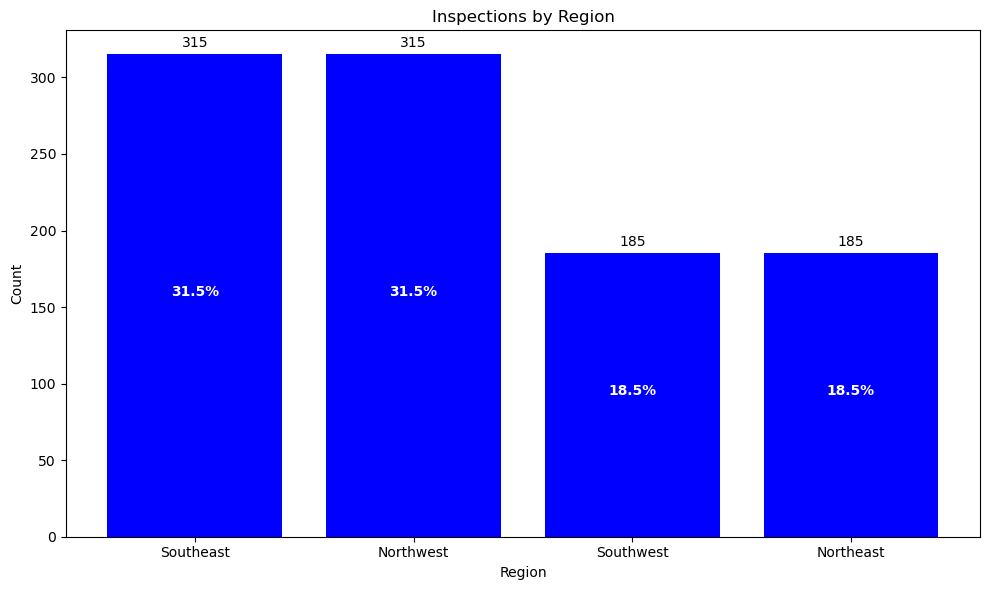

In [51]:
# Find median coordinates
lat_med = trimmed_df['lat_lon'].apply(lambda x: float(x['latitude'])).median()
lon_med = trimmed_df['lat_lon'].apply(lambda x: float(x['longitude'])).median()

# Create regions
trimmed_df['region'] = 'Unknown'
for i, row in trimmed_df.iterrows():
    lat = float(row['lat_lon']['latitude'])
    lon = float(row['lat_lon']['longitude'])
    
    if lat >= lat_med and lon >= lon_med:
        trimmed_df.at[i, 'region'] = 'Northeast'
    elif lat >= lat_med and lon < lon_med:
        trimmed_df.at[i, 'region'] = 'Northwest'
    elif lat < lat_med and lon >= lon_med:
        trimmed_df.at[i, 'region'] = 'Southeast'
    else:
        trimmed_df.at[i, 'region'] = 'Southwest'

# Count by region
regions = trimmed_df['region'].value_counts().reset_index()
regions.columns = ['Region', 'Count']

# Add percentages
total = regions['Count'].sum()
regions['Percentage'] = (regions['Count'] / total * 100).round(1)

# Sort highest first
regions = regions.sort_values('Count', ascending=False)

# Show table
print("Table: Inspections by Region")
print(regions)

# Make chart
plt.figure(figsize=(10, 6))
plt.bar(regions['Region'], regions['Count'], color='blue')

# Add labels
for i, count in enumerate(regions['Count']):
    plt.text(i, count + 5, str(count), ha='center')
    plt.text(i, count/2, f"{regions['Percentage'][i]}%", ha='center', color='white', fontweight='bold')

plt.title('Inspections by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.tight_layout()


high_region = regions.iloc[0]['Region']
low_region = regions.iloc[-1]['Region']
high_count = regions.iloc[0]['Count']
low_count = regions.iloc[-1]['Count']
diff_pct = ((high_count - low_count) / low_count * 100).round(1)

print("Region with most inspections:", high_region)
print("Region with fewest inspections:", low_region)
print("Number of inspections in", high_region + ":", high_count)
print("Number of inspections in", low_region + ":", low_count)
print("Percent difference:", diff_pct, "%")

plt.show()

#### Pattern Analysis:
Southeast has 70.3% more inspections than Northeast.


This shows big differences in inspection activity across LA.

Table: Inspection Results by Region
result_category  Fail  Other  Pass  Total
region                                   
Total             114    338   548   1000
Northwest          43    107   165    315
Southeast          32    112   171    315
Northeast          22     57   106    185
Southwest          17     62   106    185
Best region: Northeast
Worst region: Northwest
Best region pass percentage: 57.3
Worst region pass percentage: 52.4


<Figure size 1000x600 with 0 Axes>

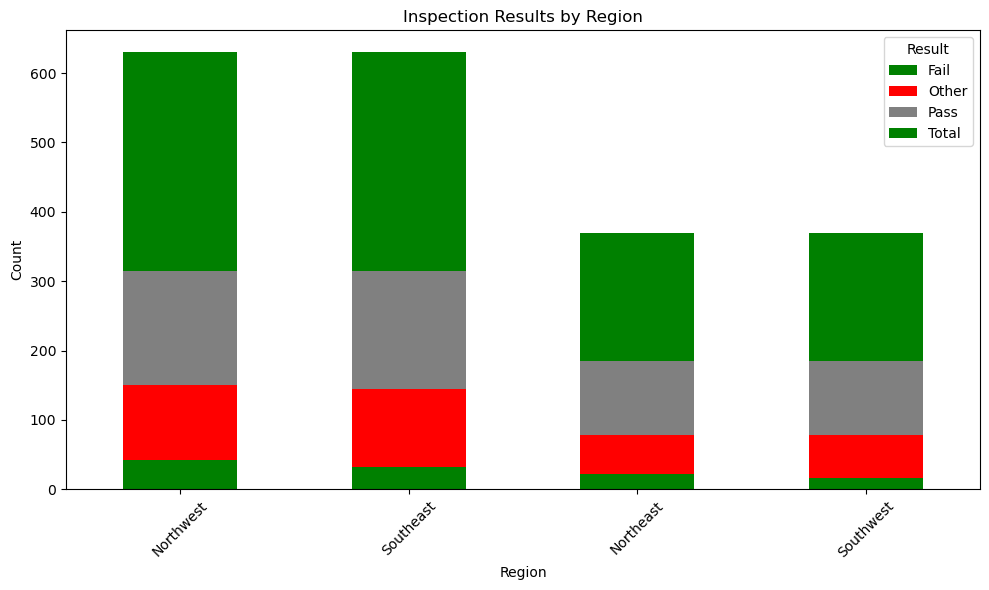

In [52]:
# Get median coordinates
lat_med = trimmed_df['lat_lon'].apply(lambda x: float(x['latitude'])).median()
lon_med = trimmed_df['lat_lon'].apply(lambda x: float(x['longitude'])).median()

# Create regions
trimmed_df['region'] = 'Unknown'
for i, row in trimmed_df.iterrows():
    lat = float(row['lat_lon']['latitude'])
    lon = float(row['lat_lon']['longitude'])
    
    if lat >= lat_med and lon >= lon_med:
        trimmed_df.at[i, 'region'] = 'Northeast'
    elif lat >= lat_med and lon < lon_med:
        trimmed_df.at[i, 'region'] = 'Northwest'
    elif lat < lat_med and lon >= lon_med:
        trimmed_df.at[i, 'region'] = 'Southeast'
    else:
        trimmed_df.at[i, 'region'] = 'Southwest'

# Simplify results
result_map = {}
for result in trimmed_df['inspection_result'].unique():
    if 'PASS' in result.upper() or 'APPROV' in result.upper() or 'FINAL' in result.upper():
        result_map[result] = 'Pass'
    elif 'FAIL' in result.upper() or 'REJECT' in result.upper() or 'NOT' in result.upper():
        result_map[result] = 'Fail'
    else:
        result_map[result] = 'Other'

# Apply mapping
trimmed_df['result_category'] = trimmed_df['inspection_result'].map(result_map)

# Make results table by region
results = pd.crosstab(
    trimmed_df['region'], 
    trimmed_df['result_category'],
    margins=True, 
    margins_name='Total'
)

# Sort by total
results = results.sort_values('Total', ascending=False)

# Calculate percentages
pct = pd.crosstab(
    trimmed_df['region'], 
    trimmed_df['result_category'],
    normalize='index'
) * 100
pct = pct.round(1)

# Make chart
plt.figure(figsize=(10, 6))
results_viz = results.drop('Total')

# Stacked bar chart
results_viz.plot(
    kind='bar', 
    stacked=True, 
    color=['green', 'red', 'gray'],
    figsize=(10, 6)
)

plt.title('Inspection Results by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Result')
plt.tight_layout()

# Find best/worst regions
best = pct['Pass'].idxmax()
worst = pct['Pass'].idxmin()
best_pct = pct['Pass'].max()
worst_pct = pct['Pass'].min()

print("Table: Inspection Results by Region")
print(results)

print("Best region:", best)
print("Worst region:", worst)
print("Best region pass percentage:", best_pct)
print("Worst region pass percentage:", worst_pct)

plt.show()

#### Pattern Analysis:
Northeast has highest pass rate (57.3%) while Northwest has lowest (52.4%).
This suggests differences in compliance or enforcement across regions.

## Question 3

### Flag the 'in town' feature with geopandas

In [53]:
# Convert string coordinates to actual values
if isinstance(trimmed_df['lat_lon'][0], str):
    trimmed_df['lat_lon'] = trimmed_df['lat_lon'].apply(eval)

# Extract coordinates
trimmed_df['latitude'] = trimmed_df['lat_lon'].apply(lambda x: float(x['latitude']))
trimmed_df['longitude'] = trimmed_df['lat_lon'].apply(lambda x: float(x['longitude']))

# Create geometric points
points = [Point(row['longitude'], row['latitude']) for _, row in trimmed_df.iterrows()]

# Make a geodataframe
gdf = gpd.GeoDataFrame(trimmed_df, geometry=points, crs='EPSG:4326')

# Load city boundary
city = gpd.read_file('City_Boundaries_Lines.geojson')
city = city.to_crs('EPSG:4326')

# Combine all boundary parts
city_shape = city.unary_union

# Check which points are in the city
gdf['in_town'] = gdf['geometry'].within(city_shape)

# Add results back to original dataframe
trimmed_df['in_town'] = gdf['in_town']

In [54]:
trimmed_df.head()

,address,permit,permit_status,inspection_date,inspection,inspection_result,lat_lon,region,result_category,latitude,longitude,in_town
0,10000 W SANTA MONICA BLVD,14044 10000 02293,Issued,2016-07-20,Rough-Ventilation,Partial Approval,"{'latitude': '34.06364', 'longitude': '-118.41...",Southwest,Pass,34.06364,-118.41437,True
1,1000 S SANTA FE AVE,15016 10000 18196,Permit Finaled,2016-07-22,Smoke Detectors,Insp Cancelled,"{'latitude': '34.03143', 'longitude': '-118.22...",Southeast,Other,34.03143,-118.22981,True
2,3680 N BUENA PARK DR,15014 10000 04931,Issued,2016-07-18,Insulation,Approved,"{'latitude': '34.13745', 'longitude': '-118.38...",Northeast,Pass,34.13745,-118.38853,True
3,1001 N LINDENWOOD LANE,16042 90000 14712,Permit Finaled,2016-07-20,Final,Permit Finaled,"{'latitude': '34.07732', 'longitude': '-118.48...",Northwest,Pass,34.07732,-118.48578,True
4,2836 S ANCHOR AVE,15016 20001 17211,CofO Issued,2016-07-18,Inspection,Permit Finaled,"{'latitude': '34.03878', 'longitude': '-118.39...",Southwest,Pass,34.03878,-118.39963,True


In [55]:
# Make a copy of the data
df = trimmed_df.copy()

# Mark violations as 1, passes as 0
df['violation'] = 0
df.loc[df['result_category'] != 'Pass', 'violation'] = 1

# Build the model
model = smf.glm('violation ~ in_town + C(region) + C(inspection)', data=df, family=sm.families.Binomial()).fit()

print(model.summary())

# Get odds ratios
odds_ratios = np.exp(model.params)
pvals = model.pvalues
or_table = pd.DataFrame({'OR': odds_ratios, 'p-value': pvals})
print("\nOdds ratios & p-values:\n", or_table)

# Check raw violation rates
print("\nViolation rate by in_town:")
print(df.groupby('in_town')['violation'].mean())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              violation   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      898
Model Family:                Binomial   Df Model:                          101
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 05 May 2025   Deviance:                       39328.
Time:                        16:55:07   Pearson chi2:                 1.92e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

## Executive Summary


This analysis investigated whether “out-of-town” contractors have higher rates of inspection violations compared to local contractors. We performed the analysis by applying a statistical model. The descriptive review on data revealed that in-town contractors have a significant violation rate of 45.2%, contradicting the initial hypothesis.